# Loading the Dataset

In [15]:
import os
train_file= "propaganda_train.tsv"

test_file= "propaganda_val.tsv"


# Pre-Processing

In [16]:
import pandas as pd
train_df=pd.read_csv(train_file,delimiter="\t",quotechar='|')
test_df=pd.read_csv(test_file,delimiter="\t",quotechar='|')


In [3]:
train_df.head(20)

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
6,not_propaganda,A federal judge on Monday ordered U.S. immigra...
7,not_propaganda,<BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
8,doubt,"As noted above, at this point literally every ..."
9,not_propaganda,Britain doesn't need more hate even just for a...


# Splitting Features and Labels 

In [19]:
train_label = train_df['label']
test_label = test_df['label']
train_features = train_df['tagged_in_context']
test_features = test_df['tagged_in_context']

# Converting Label into Binary Values 

In [18]:
binary_label_test= test_df['label'].apply(lambda x: 0 if 'not_propaganda' in x.lower() else 1)
binary_label_train= train_df['label'].apply(lambda x: 0 if 'not_propaganda' in x.lower() else 1)

In [17]:
X_train= train_features
Y_train= binary_label_train
X_test=test_features
Y_test= binary_label_test


# Task 1

# Approach 1  

# Logistic Regression - Bag of Words using Count Vectorizer


In [11]:
#Importing the necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#using the count vectorizer to transform xtrain and test data into vectors 
vectorizer=CountVectorizer()
vectorizer.fit(X_train)
Xvectors_train = vectorizer.transform(X_train)
Xvectors_test = vectorizer.transform(X_test)
#Defining the logisitc classifier
classifier_logistic = LogisticRegression(solver='saga', max_iter=1000)
#Training the model
classifier_logistic.fit(Xvectors_train, Y_train)
#Predicting the test data
pred_logistic= classifier_logistic.predict(Xvectors_test)
report_logistic = classification_report(Y_test,pred_logistic)
# Printing classification report
print("Classification Report for Logistic Regression:")
print(report_logistic)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       331
           1       0.74      0.67      0.71       309

    accuracy                           0.73       640
   macro avg       0.73      0.73      0.73       640
weighted avg       0.73      0.73      0.73       640



# Logistic Regression - Hypertuning through Random Search CV

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


# Defining hyperparameter distributions
param_dist = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'C': uniform(0.1, 10)}

# Initializing RandomizedSearchCV
random_search = RandomizedSearchCV(classifier_logistic, param_distributions=param_dist, n_iter=10, scoring='f1_weighted', cv=5, random_state=42)

# Performing Randomized Search
random_search.fit(Xvectors_train, Y_train)

# Getting best parameters
best_params_logistic = random_search.best_params_

# Training the final model using the best parameters
classifier_logistic = LogisticRegression(**best_params_logistic)
classifier_logistic.fit(Xvectors_train, Y_train)

# Making predictions on test set
pred_logistic_tuned = classifier_logistic.predict(Xvectors_test)

# Generating classification report
report_logistic_tuned = classification_report(Y_test, pred_logistic_tuned)

# Printing classification report and best parameters
print("Classification Report for Logistic Regression:")
print(report_logistic_tuned)
print("Best Parameters:", best_params_logistic)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       331
           1       0.75      0.64      0.69       309

    accuracy                           0.72       640
   macro avg       0.73      0.72      0.72       640
weighted avg       0.73      0.72      0.72       640

Best Parameters: {'C': 0.10778765841014329, 'max_iter': 100, 'solver': 'newton-cg'}


# Approach 2 


# LSTM - Static Word Embeddings/text-to-Sequence

In [51]:
#Importing Necessary Libraries

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")



# Tokenizating the x_train
max_words = 30 # Maximum number of words to tokenize
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

#converting into text_to_sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = max(len(seq) for seq in X_train_sequences)  # Finding the maximum sequence length

X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')


# Building LSTM model
embedding_dim = 100  
lstm_units = 100 

model = Sequential()
model.add(Embedding(input_dim= max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=lstm_units, return_sequences=True)) #
model.add(Dropout(0.2))
model.add(LSTM(units=lstm_units))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train_pad, binary_label_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluating the model
loss, accuracy_LSTM = model.evaluate(X_test_pad, binary_label_test)
print("Test Accuracy:", accuracy_LSTM)


# Getting the predicted labels

y_pred_LSTM = np.argmax(model.predict(X_test_pad), axis=1)
# Generating classification report
report_LSTM = classification_report(binary_label_test, y_pred_LSTM)

# Printing classification report
print("Classification Report of LSTM:")
print(report_LSTM)

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5070 - loss: 0.7371 - val_accuracy: 0.5469 - val_loss: 0.6919
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4872 - loss: 0.7229 - val_accuracy: 0.5469 - val_loss: 0.6887
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4809 - loss: 0.7190 - val_accuracy: 0.4453 - val_loss: 0.7488
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4927 - loss: 0.7169 - val_accuracy: 0.5625 - val_loss: 0.6897
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5065 - loss: 0.7009 - val_accuracy: 0.5625 - val_loss: 0.6869
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5202 - loss: 0.6924
Test Accuracy: 0.5218750238418579
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report of LSTM:
              precision    recall  f1-score   support

           0       0.52      0.99      0.68       331
           1       0.71      0.02      0.03       309

    accuracy               

## Class Imbalance Graph

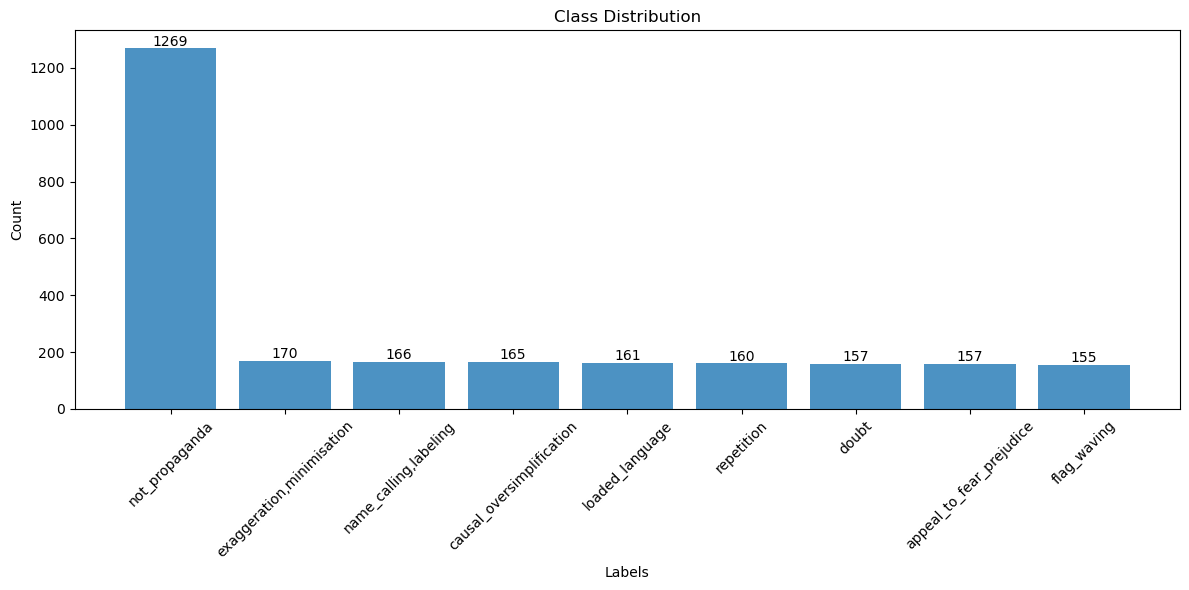

In [59]:
import matplotlib.pyplot as plt

# Assuming you have the label counts stored in a dictionary called 'label_counts'
label_counts = {
    'not_propaganda': 1269,
    'exaggeration,minimisation': 170,
    'name_calling,labeling': 166,
    'causal_oversimplification': 165,
    'loaded_language': 161,
    'repetition': 160,
    'doubt': 157,
    'appeal_to_fear_prejudice': 157,
    'flag_waving': 155
}

# Extract the labels and counts from the dictionary
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.8
opacity = 0.8

# Plot the bars
ax.bar(labels, counts, width=bar_width, alpha=opacity)

# Customize the plot
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Add labels on top of each bar
for i, count in enumerate(counts):
    ax.text(i, count + 10, str(count), ha='center')

# Display the plot
plt.tight_layout()
plt.show()

# LSTM Hypertuning - Cycle 1 

In [25]:
from tensorflow.keras import optimizers
# Building LSTM model
embedding_dim = 64  # adjusting to new values
lstm_units = 64  # adjusting to new values

model = Sequential()
model.add(Embedding(input_dim= max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=lstm_units))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train_pad, binary_label_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluating the model
loss, accuracy_LSTM_tuned = model.evaluate(X_test_pad, binary_label_test)
print("Test Accuracy:", accuracy_LSTM_tuned)


# Getting the predicted labels

y_pred_LSTM_tuned = np.argmax(model.predict(X_test_pad), axis=1)
# Generating classification report
report_LSTM_tuned = classification_report(binary_label_test, y_pred_LSTM_tuned)

# Printing classification report
print("Classification Report LSTM Tuned:")
print(report_LSTM_tuned)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4993 - loss: 0.7390 - val_accuracy: 0.5078 - val_loss: 0.6950
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5216 - loss: 0.7119 - val_accuracy: 0.6055 - val_loss: 0.6650
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5780 - loss: 0.6909 - val_accuracy: 0.5742 - val_loss: 0.6897
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5804 - loss: 0.6874 - val_accuracy: 0.6035 - val_loss: 0.6615
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6228 - loss: 0.6581 - val_accuracy: 0.6289 - val_loss: 0.6482
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6082 - loss: 0.6558 - val_accuracy: 0.6152 - val_loss: 0.6574
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6300 - loss: 0.6462 - val_accuracy: 0.6133 - val_loss: 0.6494
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6170 - loss: 0.6637 - val_accuracy: 0.6328 - v

# LSTM Hypertuning - Cycle 2

In [29]:
from tensorflow.keras import optimizers
# Building LSTM model
embedding_dim = 200  # adjusting new parameters
lstm_units = 128  # adjusting new parameters

model = Sequential()
model.add(Embedding(input_dim= max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=lstm_units))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu')) # changing activation function to relu 
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train_pad, binary_label_train, epochs=10, batch_size=16, validation_split=0.2) # changing batch size

# Evaluating the model
loss, accuracy_LSTM_tuned = model.evaluate(X_test_pad, binary_label_test)
print("Test Accuracy:", accuracy_LSTM_tuned)


# Getting the predicted labels

y_pred_LSTM_tuned = np.argmax(model.predict(X_test_pad), axis=1)
# Generating classification report
report_LSTM_tuned = classification_report(binary_label_test, y_pred_LSTM_tuned)

# Printing classification report
print("Classification Report of LSTM Tuned:")
print(report_LSTM_tuned)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4906 - loss: 0.7001 - val_accuracy: 0.5938 - val_loss: 0.6776
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5237 - loss: 0.6989 - val_accuracy: 0.4961 - val_loss: 0.6940
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4975 - loss: 0.6947 - val_accuracy: 0.5078 - val_loss: 0.6924
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5118 - loss: 0.6922 - val_accuracy: 0.6035 - val_loss: 0.6739
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5794 - loss: 0.6819 - val_accuracy: 0.5703 - val_loss: 0.6648
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5964 - loss: 0.6657 - val_accuracy: 0.6113 - val_loss: 0.6602
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6290 - loss: 0.6533 - val_accuracy: 0.6270 - val_loss: 0.6441
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6401 - loss: 0.6424 - val_accu

# Task 2

# Getting the Snippets

In [36]:
import re

def extract_snippet(sentence): # Defining function to extract snippets
    match = re.search(r'<BOS>(.*?)<EOS>', sentence)
    if match:
        return match.group(1)
    else:
        return ''

In [37]:
train_df['snippet'] = train_df['tagged_in_context'].apply(extract_snippet) 
test_df['snippet'] = test_df['tagged_in_context'].apply(extract_snippet)

# Encoding the Lables 

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode the labels (propaganda techniques) using LabelEncoder
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])
test_df['encoded_label'] = label_encoder.fit_transform(test_df['label'])

# Approach 1

# Multinomial NB classifier - Bag of Words/Vectorization

In [41]:
#Importing necessary Libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report



# Vectorizing the text
x_train = vectorizer.fit_transform(train_df['snippet'])
y_train = train_df['encoded_label']
x_test = vectorizer.transform(test_df['snippet'])
y_test = test_df['encoded_label']


# Initializing and train the classifier
classifier_NB = MultinomialNB()
classifier_NB.fit(x_train, y_train)

# Predicting labels for the test data
y_pred_NB = classifier_NB.predict(x_test)

# Evaluating the classifier
accuracy_NB = accuracy_score(y_test, y_pred_NB)
report_NB = classification_report(y_test, y_pred_NB)

#printing Report
print("Classification Report Multinomial NB:")
print(report_NB)
print()

Classification Report Multinomial NB:
              precision    recall  f1-score   support

           0       0.40      0.09      0.15        43
           1       0.50      0.31      0.39        35
           2       0.15      0.05      0.07        43
           3       0.67      0.13      0.22        30
           4       0.83      0.33      0.48        45
           5       0.00      0.00      0.00        39
           6       0.33      0.03      0.05        34
           7       0.57      0.97      0.72       331
           8       0.60      0.07      0.13        40

    accuracy                           0.56       640
   macro avg       0.45      0.22      0.25       640
weighted avg       0.51      0.56      0.46       640




# Multinomial NB classifier Hypertuning through Grid Search CV

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Defining the hyperparameter grid
param_grid_NB = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Creating the Multinomial Naive Bayes classifier
classifier_NB = MultinomialNB()

# Performing grid search
grid_search_NB = GridSearchCV(estimator=classifier_NB, param_grid=param_grid_NB, cv=5, scoring='accuracy')
grid_search_NB.fit(x_train, y_train)

# Getting the best hyperparameters and best score
best_params_NB = grid_search_NB.best_params_
best_score_NB = grid_search_NB.best_score_

print("Best hyperparameters: ", best_params_NB)
print("Best accuracy score: ", best_score_NB)

# Training the classifier with the best hyperparameters
best_classifier = MultinomialNB(alpha=best_params_NB['alpha'])
best_classifier.fit(x_train, y_train)

# Predicting labels for the test data using the best classifier
y_pred_NB_tuned = best_classifier.predict(x_test)

accuracy_NB_tuned = accuracy_score(y_test, y_pred_NB_tuned)
report_NB_tuned = classification_report(y_test, y_pred_NB_tuned)

#Priting classification report
print("Classification Report Multinomial NB Tuned:")
print(report_NB_tuned)
print()

Best hyperparameters:  {'alpha': 0.5}
Best accuracy score:  0.5421875
Classification Report Multinomial NB Tuned:
              precision    recall  f1-score   support

           0       0.40      0.19      0.25        43
           1       0.44      0.46      0.45        35
           2       0.35      0.30      0.32        43
           3       0.47      0.27      0.34        30
           4       0.81      0.47      0.59        45
           5       0.70      0.18      0.29        39
           6       0.44      0.12      0.19        34
           7       0.64      0.91      0.75       331
           8       0.60      0.15      0.24        40

    accuracy                           0.60       640
   macro avg       0.54      0.34      0.38       640
weighted avg       0.59      0.60      0.55       640




# Approach 2

# Random Forest Classifier-  Word2Vec/Word Embedding

In [43]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

#creating tokens 
x_train_tokens = [str(doc).split() for doc in x_train]
x_test_tokens = [str(doc).split() for doc in x_test]

# Training Word2Vec model
embedding_size = 100
window_size = 5
min_word_count = 1

word2vec_model = Word2Vec(x_train_tokens, vector_size=embedding_size, window=window_size, min_count=min_word_count)

# Creating document embeddings
def get_document_embedding(doc): #defining the function to get the embeddings
    valid_words = [word for word in doc if word in word2vec_model.wv]
    if valid_words:
        doc_embedding = np.mean(word2vec_model.wv[valid_words], axis=0)
    else:
        doc_embedding = np.zeros(embedding_size)
    return doc_embedding

X_train_embeddings = [get_document_embedding(doc) for doc in x_train_tokens]
X_test_embeddings = [get_document_embedding(doc) for doc in x_test_tokens]

# Training Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train_embeddings, y_train)

# Predicting labels for the test set
y_pred_rf = rf_classifier.predict(X_test_embeddings)
report_rf = classification_report(y_test, y_pred_rf)

# Print classification report
print("Classification Report: Random Forest")
print(report_rf)

Classification Report: Random Forest
              precision    recall  f1-score   support

           0       0.12      0.07      0.09        43
           1       0.15      0.14      0.15        35
           2       0.31      0.09      0.14        43
           3       0.43      0.10      0.16        30
           4       0.64      0.31      0.42        45
           5       0.00      0.00      0.00        39
           6       0.56      0.15      0.23        34
           7       0.59      0.92      0.72       331
           8       0.71      0.25      0.37        40

    accuracy                           0.54       640
   macro avg       0.39      0.23      0.25       640
weighted avg       0.48      0.54      0.47       640



# Random Forest Classifier Hypertuning through Grid search CV

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Creating a Random Forest classifier
classifier_rf_tuned = RandomForestClassifier()

# Performing grid search
grid_search_rf = GridSearchCV(estimator=classifier_rf_tuned, param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_embeddings, y_train)

# Getting the best hyperparameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best hyperparameters:", best_params_rf)
print("Best accuracy score:", best_score_rf)

# Training the Random Forest classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_params_rf)
best_rf_classifier.fit(X_train_embeddings, y_train)

# Predicting labels for the test set
y_pred_rf_tuned = best_rf_classifier.predict(X_test_embeddings)
report_rf_tuned = classification_report(y_test, y_pred_rf_tuned)

# Printing classification report
print("Classification Report:")
print(report_rf_tuned)

Best hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best accuracy score: 0.519140625
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.09      0.12        43
           1       0.10      0.09      0.09        35
           2       0.27      0.07      0.11        43
           3       1.00      0.10      0.18        30
           4       0.74      0.31      0.44        45
           5       0.20      0.03      0.05        39
           6       0.43      0.09      0.15        34
           7       0.58      0.93      0.72       331
           8       0.90      0.23      0.36        40

    accuracy                           0.54       640
   macro avg       0.49      0.21      0.25       640
weighted avg       0.53      0.54      0.46       640



# Approach 3 

# BERT - Bert Tokenizer/Conextual Embedding


In [84]:
#importing the necessary libraries 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
import warnings
warnings.filterwarnings("ignore")

# Loading the BERT tokenizer and model
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Tokenizing the snippets
train_encodings = tokenizer_bert(list(train_df['snippet']), truncation=True, padding=True)
test_encodings = tokenizer_bert(list(test_df['snippet']), truncation=True, padding=True)

# Creating the datasets
class SnippetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
train_dataset = SnippetDataset(train_encodings, train_df['encoded_label'])
test_dataset = SnippetDataset(test_encodings, test_df['encoded_label'])

# Creating the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Batch [{batch_idx + 1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total

    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    print()

Epoch 1/3
--------------------
Batch [10/160] Loss: 1.8466
Batch [20/160] Loss: 2.0592
Batch [30/160] Loss: 1.8655
Batch [40/160] Loss: 1.3563
Batch [50/160] Loss: 1.7038
Batch [60/160] Loss: 1.6123
Batch [70/160] Loss: 1.2840
Batch [80/160] Loss: 1.1303
Batch [90/160] Loss: 1.6481
Batch [100/160] Loss: 1.5159
Batch [110/160] Loss: 1.3203
Batch [120/160] Loss: 1.5161
Batch [130/160] Loss: 1.6452
Batch [140/160] Loss: 1.3491
Batch [150/160] Loss: 1.3477
Batch [160/160] Loss: 0.6527
Training Loss: 1.4833 | Training Accuracy: 0.5145

Epoch 2/3
--------------------
Batch [10/160] Loss: 1.1229
Batch [20/160] Loss: 0.7942
Batch [30/160] Loss: 1.2326
Batch [40/160] Loss: 0.8305
Batch [50/160] Loss: 1.1993
Batch [60/160] Loss: 0.7442
Batch [70/160] Loss: 0.7344
Batch [80/160] Loss: 0.9553
Batch [90/160] Loss: 0.9049
Batch [100/160] Loss: 0.3799
Batch [110/160] Loss: 0.6211
Batch [120/160] Loss: 0.7311
Batch [130/160] Loss: 0.8756
Batch [140/160] Loss: 0.3865
Batch [150/160] Loss: 0.5988
Batch 

### Evaluating the BERT  Model

In [14]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Calculating accuracy and classification report
accuracy_BERT = accuracy_score(y_true, y_pred)
report_BERT = classification_report(y_true, y_pred, target_names=label_encoder.classes_)

print("Approach: BERT")
print("Accuracy:", accuracy_BERT)
print("Classification Report:")
print(report_BERT)

Approach: BERT
Accuracy: 0.753125
Classification Report:
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.62      0.65      0.64        43
causal_oversimplification       0.49      0.74      0.59        35
                    doubt       0.61      0.53      0.57        43
exaggeration,minimisation       0.51      0.63      0.57        30
              flag_waving       0.72      0.64      0.68        45
          loaded_language       0.53      0.59      0.56        39
    name_calling,labeling       0.73      0.71      0.72        34
           not_propaganda       0.90      0.90      0.90       331
               repetition       0.65      0.28      0.39        40

                 accuracy                           0.75       640
                macro avg       0.64      0.63      0.62       640
             weighted avg       0.76      0.75      0.75       640



# BERT Hypertuning

In [30]:

# Creating the data loaders
batch_size = 32 # changing batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5) #changing learning rate
num_epochs = 6 #chaning epochs from 3 to 6

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Batch [{batch_idx + 1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total

    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    print()

Epoch 1/6
--------------------
Batch [10/80] Loss: 0.2561
Batch [20/80] Loss: 0.4143
Batch [30/80] Loss: 0.2326
Batch [40/80] Loss: 0.3965
Batch [50/80] Loss: 0.5162
Batch [60/80] Loss: 0.3210
Batch [70/80] Loss: 0.3414
Batch [80/80] Loss: 0.2554
Training Loss: 0.3080 | Training Accuracy: 0.9137

Epoch 2/6
--------------------
Batch [10/80] Loss: 0.3355
Batch [20/80] Loss: 0.3108
Batch [30/80] Loss: 0.0662
Batch [40/80] Loss: 0.1970
Batch [50/80] Loss: 0.2039
Batch [60/80] Loss: 0.0733
Batch [70/80] Loss: 0.0724
Batch [80/80] Loss: 0.1372
Training Loss: 0.1675 | Training Accuracy: 0.9586

Epoch 3/6
--------------------
Batch [10/80] Loss: 0.0601
Batch [20/80] Loss: 0.1367
Batch [30/80] Loss: 0.1318
Batch [40/80] Loss: 0.0810
Batch [50/80] Loss: 0.0744
Batch [60/80] Loss: 0.1318
Batch [70/80] Loss: 0.1384
Batch [80/80] Loss: 0.1638
Training Loss: 0.0984 | Training Accuracy: 0.9773

Epoch 4/6
--------------------
Batch [10/80] Loss: 0.0653
Batch [20/80] Loss: 0.0705
Batch [30/80] Loss: 0

### Evaluation of hypertuned BERT

In [31]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Calculating accuracy and classification report
accuracy_BERT = accuracy_score(y_true, y_pred)
report_BERT = classification_report(y_true, y_pred, target_names=label_encoder.classes_)

print("Approach: BERT")
print("Accuracy:", accuracy_BERT)
print("Classification Report:")
print(report_BERT)

Approach: BERT
Accuracy: 0.771875
Classification Report:
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.67      0.70      0.68        43
causal_oversimplification       0.57      0.83      0.67        35
                    doubt       0.67      0.56      0.61        43
exaggeration,minimisation       0.51      0.60      0.55        30
              flag_waving       0.80      0.73      0.77        45
          loaded_language       0.65      0.44      0.52        39
    name_calling,labeling       0.71      0.44      0.55        34
           not_propaganda       0.94      0.92      0.93       331
               repetition       0.40      0.60      0.48        40

                 accuracy                           0.77       640
                macro avg       0.66      0.65      0.64       640
             weighted avg       0.79      0.77      0.77       640



# CODE COUNT

In [52]:
import io
from nbformat import read

filepath = "ANLP latest.ipynb"

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = read(f, as_version=4)

word_count = 0
for cell in nb.cells:
    if cell.cell_type == "code":
        word_count += len(cell['source'].replace('#', '').lstrip().split())

print("Number of words in code cells: {}".format(word_count))

Number of words in code cells: 1660
